<a href="https://www.kaggle.com/code/ashishkumarak/fine-tuning-phi-on-t4-2-gpu?scriptVersionId=168027362" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<p><img src="https://i.ytimg.com/vi/9fVb_pbVUC0/maxresdefault.jpg" height="700" width="700" style="object-fit: cover;"></p>
<p style="text-align:justify;">
</p>  

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #F2FEFF;
    border-radius: 3px;
    font-color :  #581845  ;        
    border: 1px solid #FF5733 ;">  
Installing and importing Required Libraries

In [ ]:
%%timeit
%%capture
%pip install -U -q bitsandbytes
%pip install -U -q transformers
%pip install -U -q peft
%pip install -U -q accelerate

In [ ]:
%%timeit
%%capture
%pip uninstall datasets -y -q
%pip install -q datasets==2.16.0
%pip install -U -q trl 

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig ,HfArgumentParser,TrainingArguments,pipeline
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import os,torch, wandb
from datasets import load_dataset
from trl import SFTTrainer

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 105%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">  

Setting up the : 
1. HuggingFace Token for uploading the fine tuned adapter
2. Weights and Biases Token for tracking the training metrics
    
To get the HuggingFace token :
1. Sign up and login to your HuggingFace account and go to https://huggingface.co/settings/tokens

To get the Wandb token :
1. Sign up and login to your HuggingFace account and go to https://wandb.ai/authorize

Add them in Kaggle : 
1. Click on the Add-ons in Kaggle top menu : 
    
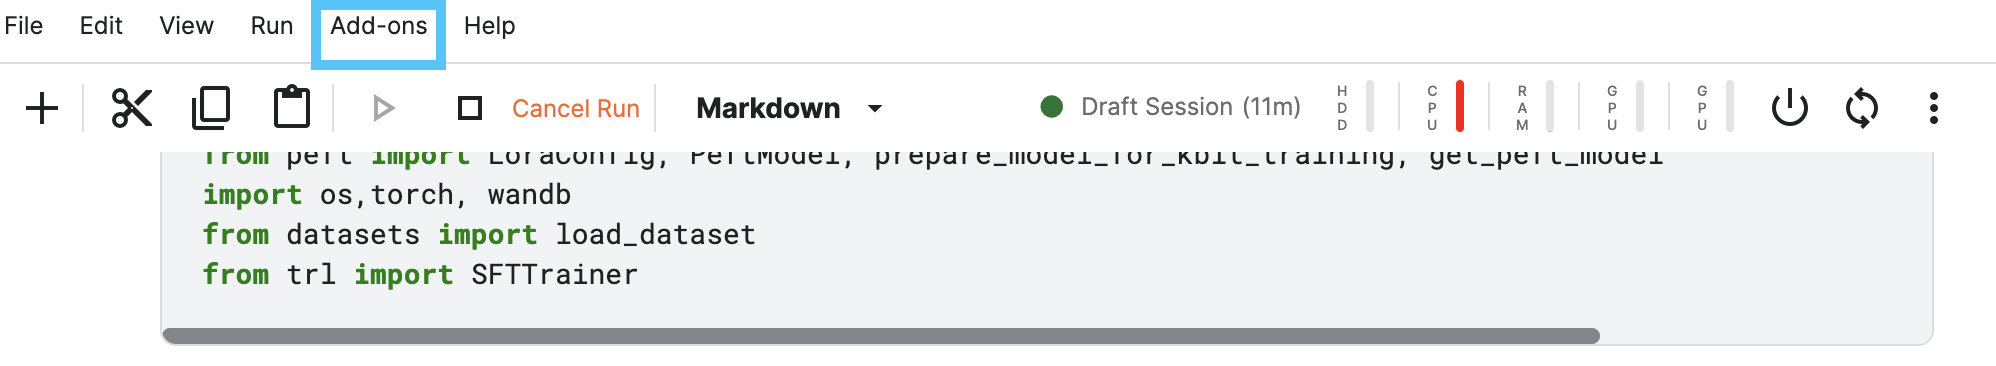

2. In the drop-down menu, choose `Secrets`
3. In the `Secrets` Tab, add both the tokens and attach them to the notebook 
    
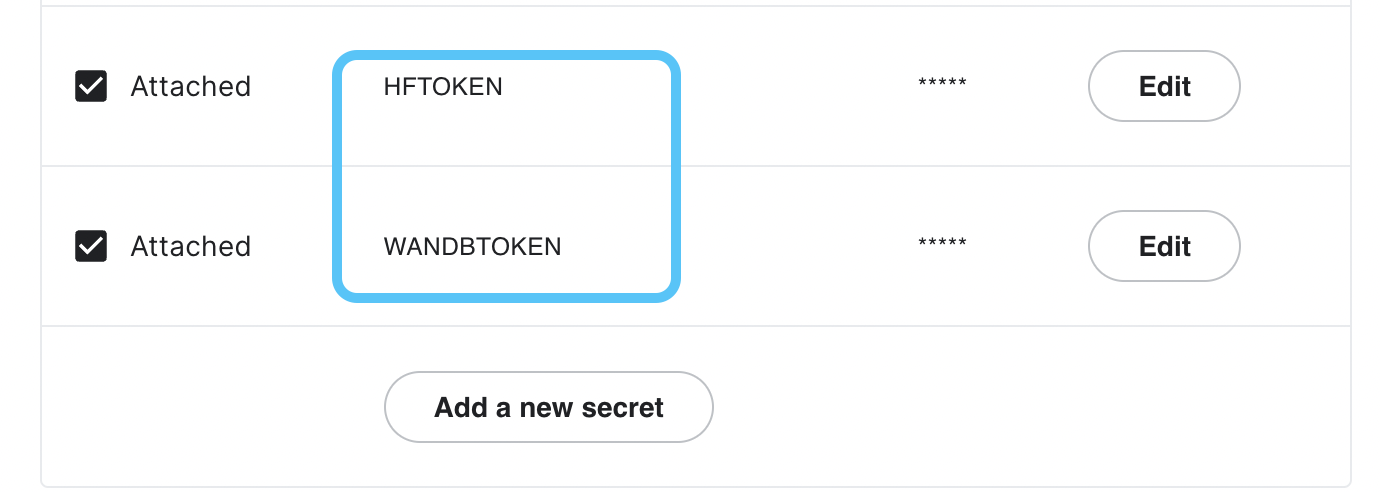

The Settings are ready to be used!

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 105%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;"> 
    
Pass the names you assigned in the `Secrets` tab here in the `get_secret` below 

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_wandb = user_secrets.get_secret("WANDBTOKEN")

In [ ]:
secret_hf = user_secrets.get_secret("HFTOKEN")
# Logging in to huggingface using cli
!huggingface-cli login --token $secret_hf

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 105%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">
    
In the Projects section of Weights and Biases, you'll see your project by the name as assigned to the `project` variable below :

In [ ]:
# Monitering the LLM
wandb.login(key = secret_wandb)
run = wandb.init(
    project='Fine tuning phi 2B(FULL T4*2)', 
    job_type="training", 
    anonymous="allow"
)

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">
    
Dataset Under Use :
    
- Here I'm using a dataset containing abstract and titles of different research papers, which had very high numbers of reads
- Intent is to use abstracts [of similar domain] during inference,  to produce 'catchy' titles that may/can maximise the reads of the paper with that abstract

In [ ]:
from datasets import load_dataset
import pandas as pd    
train_dataset = pd.read_json(path_or_buf='/kaggle/input/astrollama-files/train_classic_factor.jsonl', lines=True)
eval_dataset =pd.read_json(path_or_buf='/kaggle/input/astrollama-files/eval_classic_factor.jsonl', lines=True)

In [ ]:
train_dataset['output'] = train_dataset['output'].str.replace(r"\['|'\]", "", regex=True)
eval_dataset['output'] = eval_dataset['output'].str.replace(r"\['|'\]", "", regex=True)

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">

Using the Prompt Template as mentioned here : https://huggingface.co/microsoft/phi-2#qa-format

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_dataset)
eval_dataset = Dataset.from_pandas(eval_dataset)
def formatting_func(example):
    text = f"Instruct: {example['input']}\nOutput: {example['output']}"
    return text

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">

Loading the 8-bit quantised model. You can try without quantization as well

In [ ]:
base_model = "/kaggle/input/phi/transformers/2/1"

bnb_config = BitsAndBytesConfig(  
    load_in_8bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.bfloat16,
    bnb_4bit_use_double_quant= False,
)
model = AutoModelForCausalLM.from_pretrained(
        base_model,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
)
model.config.use_cache = False #Uses less memory during training, need to be set to True during inference
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.padding_side = 'right'
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True


In [ ]:
import gc
gc.collect()

In [ ]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">

Mapping the dataset as per the prompt template and the respective tokenizer

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

In [ ]:
print(model)

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">

Preparing the model for QLoRA fine tuning

In [ ]:

model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    r=128,
    lora_alpha=16,
    target_modules=["k_proj", "q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">

Creating a path to save checkpoints(if any)

In [ ]:
run_name = 'astrophi' 
output_dir = "./" + run_name

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">

If you have more than one gpu, below commands ensure parallelization during training

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 110%;
    background-color: #F2FEFF;
    border-radius: 5px;
    font-color :  #581845  ;                           
    border: 1px solid #FF5733 ;">

Removing any unwanted cache in VRAM and cleaning memory if any unassigned variables 

In [ ]:
torch.cuda.empty_cache()

import gc
gc.collect()

In [ ]:
import transformers
from datetime import datetime



trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        num_train_epochs=1,
        learning_rate=2.5e-4, # Want a small lr for finetuning
       fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=1,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        eval_steps=100,               # Evaluate every step
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",      
#         run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

try : 
    trainer.train()
except RuntimeError as e:
    print(e)
    if "CUDA out of memory" in str(e):
        print("CUDA out of memory error. Trying to handle.")
        print(f'Original Error : {e}')

In [ ]:
# Save the fine-tuned model 
trainer.model.save_pretrained('phi2')
#Close the wandb tracking for this process
wandb.finish()
# Set the cache to True for Inference
model.config.use_cache = True
model.eval()

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #F2FEFF;
    border-radius: 3px;
    font-color :  #581845  ;        
    border: 1px solid #FF5733 ;">  
Push the adapter and tokenizer to HuggingFace

In [ ]:
try:
    trainer.model.push_to_hub('phi2', use_temp_dir=False)
    tokenizer.push_to_hub('phi2')
except error as e:
    print("An exception occurred")

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #F2FEFF;
    border-radius: 3px;
    font-color :  #581845  ;        
    border: 1px solid #FF5733 ;">  
Inference using the adapter uploaded on HuggingFace 

In [ ]:
from peft import PeftModel, PeftConfig

model = PeftModel.from_pretrained(model, "phi2")


In [ ]:
eval_prompt  = 'Diabetes is now one of the major public health challenges, globally. Prolonged diabetes leads to various diabetic microvascular complications (DMCs) like retinopathy, nephropathy, and neuropathy. Multiple factors are likely to be involved in predisposing diabetic individuals to complications. Early detection or diagnosis is essential in developing strategies to reduce the risk factors and management costs of these diabetic complications. In this study, we employed Raman Spectroscopy (RS) to analyse the plasma samples of diabetes patients without and with DMCs along with the plasma samples of healthy subjects. Spectral comparisons revealed decrease in protein content in Diabetes group and further subsequent decrease in proteins in DMC groups when compared with control group, which corroborates with the fact that there exists increased secretion of proteins in urine and corresponding decreased protein content in their blood in case of diabetic individuals. Among all study groups, it was noted that 75% of control spectra show correct classification, while spectral misclassification is high amongst the subjects with Diabetes and DMCs. Interestingly, very few Diabetes and DMC plasma spectra are misclassified as control spectra. Findings demonstrate that 70% of the Diabetes subjects without complications can be correctly identified from diabetes with complications. Further, investigations could also attempt to explore the use of serum instead of plasma to reduce the spectral misclassifications as one of the abundant constituents namely clotting factors could be avoided. The outcome of RS study may be imminent for the early detection or diagnosis of DMCs.'

In [ ]:
pipe = pipeline(task="summarization", model=model, tokenizer=tokenizer,  max_new_tokens=50)
result = pipe(f"Instruct: {eval_prompt}\n Output: ")
print(result[0]['summary_text'].split("\n Output: ")[1])

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #F2FEFF;
    border-radius: 3px;
    font-color :  #581845  ;        
    border: 1px solid #FF5733 ;">  

The model can perform better on increasing the number of data points being used for fine tuning